In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm     as cm
import numpy             as np
import cartopy.crs       as ccrs
import cartopy.feature   as cfeature
import xarray            as xr
import os
import yaml

from matplotlib.colors import TABLEAU_COLORS

import warnings
warnings.filterwarnings("ignore")

working_directory = '/home/veilleux/Projet/Projet_SACHR/analyses_and_figures'
yml_file = working_directory + '/config.yml'
stream = open(yml_file,'r')
config = yaml.safe_load(stream)

In [2]:
dpi = 150
# step0 GEM5
ncfile = config['GEM5']['step0']
# Get lat, lon and cartopy_projection_object
ds  = xr.open_dataset(ncfile) # Dataframe from the netcdf file
lat = ds.lat.values           # 2D array with latitude
lon = ds.lon.values           # 2D array with longitude
mask = ds['MG'][0,:,:].values
mask[mask >= 0.5] = 1
mask[mask < 0.5 ] = 0
m   = ccrs.RotatedPole(ds.rotated_pole.grid_north_pole_longitude, ds.rotated_pole.grid_north_pole_latitude)
xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())
extents = [xll, xur, yll, yur]

land_mask  = mask
ocean_mask = 1 - mask

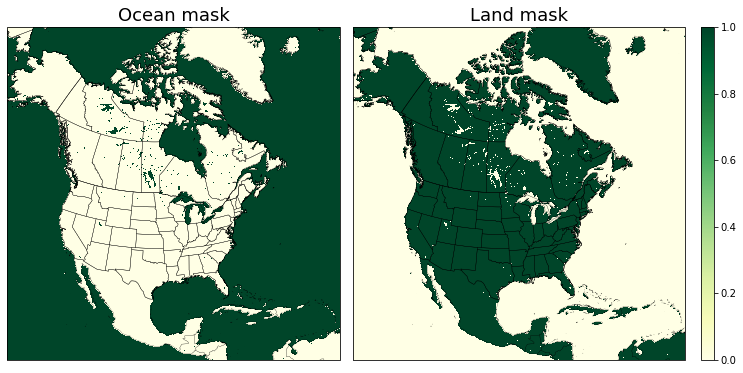

In [3]:
fig = plt.figure(figsize=(12, 6), constrained_layout = True)
l1 = 0.02
l2 = 0.42
b  = 0.75
w  = 0.5
h  = 0.77
L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')
norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
ax1 = plt.axes([l1, b, w, h],projection = m)
ax1.coastlines(resolution='10m', linewidth = 0.2)
ax1.add_feature(cfeature.OCEAN)
ax1.set_extent(extents, crs = m)
ax1.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax1.add_feature(cfeature.BORDERS, linewidth = 0.3)
ax1.set_title('Ocean mask', fontsize = 18)
ocean = ax1.pcolormesh(lon, lat,ocean_mask , cmap='YlGn',vmin=0, vmax=1, transform=ccrs.PlateCarree(), norm = norm)

    
ax2 = plt.axes([l2, b, w, h],projection = m)
ax2.coastlines(resolution='10m', linewidth = 0.2)
ax2.set_extent(extents, crs = m)
ax2.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax2.add_feature(cfeature.BORDERS, linewidth = 0.3)
ax2.set_title('Land mask', fontsize = 18)
land = ax2.pcolormesh(lon, lat,land_mask , cmap='YlGn',vmin=0, vmax=1, transform=ccrs.PlateCarree(), norm = norm)

#Colorbar             # [left,bottom,width,height]
cbar_ax1 = fig.add_axes([0.88, 0.75, 0.015, 0.77])
cbar1    = fig.colorbar(land, extend = 'neither' , cax = cbar_ax1)

plt.show()

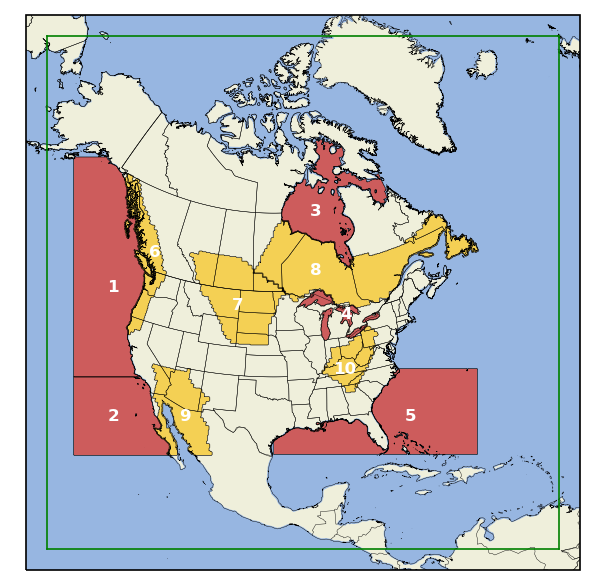

In [22]:
# Aquatic regions
ocean = ['Hudson.nc'    ,'ColdNEPacific.nc','GreatLakes.nc','WarmNEPacific.nc', 'WarmNWAtlantic.nc']
# Land regions
land =  ['Appalachia.nc','EastBoreal.nc'   ,'PacificNW.nc' ,'Southwest.nc'    , 'NPlains.nc']

dpi = 150
# step0 GEM5
ncfile = config['GEM5']['step0']
# Get lat, lon and cartopy_projection_object
ds  = xr.open_dataset(ncfile) # Dataframe from the netcdf file
lat = ds.lat.values           # 2D array with latitude
lon = ds.lon.values           # 2D array with longitude

###################################################
### Delimitation of NAM11 domain for projection ###
###################################################
m   = ccrs.RotatedPole(ds.rotated_pole.grid_north_pole_longitude, ds.rotated_pole.grid_north_pole_latitude)
xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())

# NAM11 limits
extents_NAM11 = [xll, xur, yll, yur]
# Extented NAM11 limits
extents = [xll-3, xur+3, yll-3, yur+3] 

##########################################
### Input directory for bukovsky files ###
##########################################
dir_in = config['bukovsky']['chinook'] + '/' + 'final'
# List of the files in directory
nc_files_in = [file for file in os.listdir(dir_in) if file.endswith('.nc')]

#####################################
############# Main Plot #############
#####################################
dpi = 150
fig = plt.figure()
fig.set_dpi(dpi)
ax  = plt.axes(extent = extents,projection = m)
ax.set_extent(extents, crs = m)

# Add map features
ax.coastlines(resolution='10m', linewidth = 0.2)
ax.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.2)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth = 0.2)

# Plotting every eco-regions
for index, files in enumerate(nc_files_in):
    nc_buk = dir_in + "/" + files
    ds   = xr.open_dataset(nc_buk) # Eco-region data
    lat  = ds['lat']               
    lon  = ds['lon']
    mask = ds['mask'][0,:,:]      # Mask of 0s and 1s containing the region - mask(lon,lat)
    m = np.squeeze(mask.values)
    m[m != 1.0]     = 0 # Replacing float32(nan) and float(nan) by 0 for contour
    if files in ocean:
        # Black contour
        contour   = ax.contour(lon, lat, m, levels=[0,1],colors ='k', linewidths=0.3, transform=ccrs.PlateCarree())
        m[m == 0] = np.nan
        # Filled regions with color
        ax.contourf(lon, lat, m, colors='indianred',edgecolors = 'black', transform=ccrs.PlateCarree())
    elif files in land:
        contour   = ax.contour(lon, lat, m, levels=[0,1],colors ='k', linewidths=0.3, transform=ccrs.PlateCarree())
        m[m == 0] = np.nan
        ax.contourf(lon, lat, m, colors = "#f4d054",edgecolors = 'black', transform=ccrs.PlateCarree())

ax.annotate('1' ,xy=(.18, .5)  , xycoords='figure fraction',fontsize=8, color = 'white', fontweight = 'bold')
ax.annotate('2' ,xy=(.18, .28) , xycoords='figure fraction',fontsize=8, color = 'white', fontweight = 'bold')
ax.annotate('3' ,xy=(.52, .63) , xycoords='figure fraction',fontsize=8, color = 'white', fontweight = 'bold')
ax.annotate('4' ,xy=(.571,.455), xycoords='figure fraction',fontsize=8, color = 'white', fontweight = 'bold')
ax.annotate('5' ,xy=(.68, .28) , xycoords='figure fraction',fontsize=8, color = 'white', fontweight = 'bold')
ax.annotate('6' ,xy=(.25, .56) , xycoords='figure fraction',fontsize=8, color = 'white', fontweight = 'bold')
ax.annotate('7' ,xy=(.39, .47) , xycoords='figure fraction',fontsize=8, color = 'white', fontweight = 'bold')
ax.annotate('8' ,xy=(.52, .53) , xycoords='figure fraction',fontsize=8, color = 'white', fontweight = 'bold')
ax.annotate('9' ,xy=(.30, .28) , xycoords='figure fraction',fontsize=8, color = 'white', fontweight = 'bold')
ax.annotate('10',xy=(.56, .36) , xycoords='figure fraction',fontsize=8, color = 'white', fontweight = 'bold')

########################################
#### NAM11 green square coordinates ####
########################################
# Lower_line          [lon1,lon2][lat1,lat2]
lower_lon, lower_lat = [xll,xur],[yll,yll]
ax.plot(lower_lon, lower_lat, color='g', linewidth=0.8, linestyle='-')
# Upper_line
upper_lon, upper_lat = [xll,xur],[yur,yur]
ax.plot(upper_lon, upper_lat, color='g', linewidth=0.8, linestyle='-')
# Left line
left_lon, left_lat   = [xll,xll],[yll,yur]
ax.plot(left_lon , left_lat , color='g', linewidth=0.8, linestyle='-')
# Right line
right_lon, right_lat = [xur,xur],[yll,yur]
ax.plot(right_lon, right_lat, color='g', linewidth=0.8, linestyle='-')

plt.tight_layout()
plt.show()

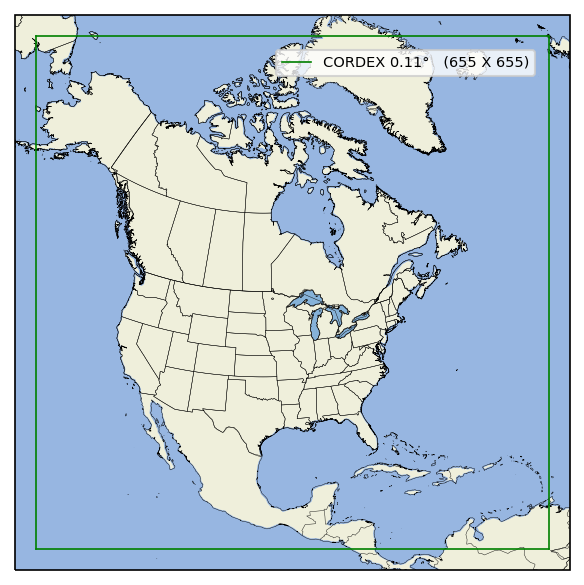

In [53]:
dpi = 150
# step0 GEM5
ncfile = config['GEM5']['step0']
# Get lat, lon and cartopy_projection_object
ds  = xr.open_dataset(ncfile) # Dataframe from the netcdf file
lat = ds.lat.values           # 2D array with latitude
lon = ds.lon.values           # 2D array with longitude

###################################################
### Delimitation of NAM11 domain for projection ###
###################################################
m   = ccrs.RotatedPole(ds.rotated_pole.grid_north_pole_longitude, ds.rotated_pole.grid_north_pole_latitude)
xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())

# NAM11 limits
extents_NAM11 = [xll, xur, yll, yur]
# Extented NAM11 limits
extents = [xll-3, xur+3, yll-3, yur+3] 

#####################################
############# Main Plot #############
#####################################
dpi = 150
fig = plt.figure()
fig.set_dpi(dpi)
ax  = plt.axes(extent = extents,projection = m)
ax.set_extent(extents, crs = m)

# Add map features
ax.coastlines(resolution='10m', linewidth = 0.2)
ax.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.2)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth = 0.2)

# Plotting every eco-regions
for index, files in enumerate(nc_files_in):
    nc_buk = dir_in + "/" + files
    ds   = xr.open_dataset(nc_buk) # Eco-region data
    lat  = ds['lat']               
    lon  = ds['lon']
    mask = ds['mask'][0,:,:]      # Mask of 0s and 1s containing the region - mask(lon,lat)
    m = np.squeeze(mask.values)
    m[m != 1.0]     = 0 # Replacing float32(nan) and float(nan) by 0 for contour
    if "GreatLakes" in files:
        # Black contour
        contour   = ax.contour(lon, lat, m, levels=[0,1],colors ='k', linewidths=0.3, transform=ccrs.PlateCarree())
        m[m == 0] = np.nan
        # Filled regions with color
        ax.contourf(lon, lat, m, colors='#86b2d8', edgecolors = 'black', transform=ccrs.PlateCarree())

        ########################################
#### NAM11 green square coordinates ####
########################################
# Lower_line          [lon1,lon2][lat1,lat2]
lower_lon, lower_lat = [xll,xur],[yll,yll]
ax.plot(lower_lon, lower_lat, color='g', linewidth=0.8, linestyle='-')
# Upper_line
upper_lon, upper_lat = [xll,xur],[yur,yur]
ax.plot(upper_lon, upper_lat, color='g', linewidth=0.8, linestyle='-')
# Left line
left_lon, left_lat   = [xll,xll],[yll,yur]
ax.plot(left_lon , left_lat , color='g', linewidth=0.8, linestyle='-')
# Right line
right_lon, right_lat = [xur,xur],[yll,yur]
ax.plot(right_lon, right_lat, color='g', linewidth=0.8, linestyle='-', label ='CORDEX 0.11'+ u'\N{DEGREE SIGN}'+'   (655 X 655)')

ax.legend(loc = 'upper right', bbox_to_anchor=(0.95, 0.95), prop={'size': 7})

plt.tight_layout()
plt.show()